In [40]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from time import time
from matplotlib import dates as mdates
from datetime import datetime, timedelta
from nltk.tokenize import word_tokenize
import xgboost as xgb
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (15,5)

In [62]:
tram_delays_raw = pd.read_csv('/home/karol/ed/tram_delays_0.csv')

In [100]:
tram_delays_df = pd.DataFrame.copy(tram_delays_raw)
tram_delays_df['time'] = pd.to_datetime(tram_delays_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
tram_delays_df['time'] = [x.replace(year=2000, month=1, day=1, second=0, microsecond=0) for x in tram_delays_df['time']]
tram_delays_df = tram_delays_df.sort_values(by=['time'])

In [101]:
tram_delays_df.head(10)

,Unnamed: 0,vehicleId,direction,patternText,tripId,stopName,time,day_of_week,delay
1113642,1113642,6352185295672180860,Kombinat,22,6351558574044832787,Plac Centralny im. R.Reagana,2000-01-01,2,-1
2027514,2027514,6352185295672181550,Czerwone Maki P+R,18,6351558574047683861,Kampus UJ,2000-01-01,3,2
2027519,2027519,6352185295672180871,Kombinat,22,6351558574047761683,Hala Targowa,2000-01-01,3,-1
2027522,2027522,6352185295672181339,Plac Centralny im.R.Reagana,62,6351558574048019716,Chmieleniec,2000-01-01,3,1
2027526,2027526,6352185295672181384,Nowy Bieżanów P+R,3,6351558574048036099,Nowy Prokocim,2000-01-01,3,0
2027549,2027549,6352185295672181347,Krowodrza Górka,69,6351558574048032004,Bieżanowska,2000-01-01,3,0
2945563,2945563,6352185295672181367,Plac Centralny im.R.Reagana,62,6351558574047065604,Chmieleniec,2000-01-01,4,1
2027559,2027559,6352185295672181550,Czerwone Maki P+R,18,6351558574047683861,Kampus UJ,2000-01-01,3,2
2027565,2027565,6352185295672180871,Kombinat,22,6351558574047761683,Hala Targowa,2000-01-01,3,-1
182632,182632,6352185295672180842,Kombinat,22,6351558574044848913,Ofiar Dąbia,2000-01-01,1,0


In [65]:
grouped_tram_delays = tram_delays_df.groupby(['stopName', 'patternText', 'direction'])

In [66]:
result = [g[1] for g in list(grouped_tram_delays)[:1]][0]
result.head(10)

,Unnamed: 0,vehicleId,direction,patternText,tripId,stopName,time,day_of_week,delay
2958225,2958225,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:40:00,5,0
2958576,2958576,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958641,2958641,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958419,2958419,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958465,2958465,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958791,2958791,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958878,2958878,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958287,2958287,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958343,2958343,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0
2958379,2958379,6352185295672181162,Krowodrza Górka,5,6351558574045345538,AWF,2000-01-01 04:41:00,5,0


In [67]:
_times = list(sorted(result['time'].values))
print('Times from %s to %s' % (_times[0], _times[-1]))

Times from 2000-01-01T04:40:00.000000000 to 2000-01-01T23:02:00.000000000


/home/karol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


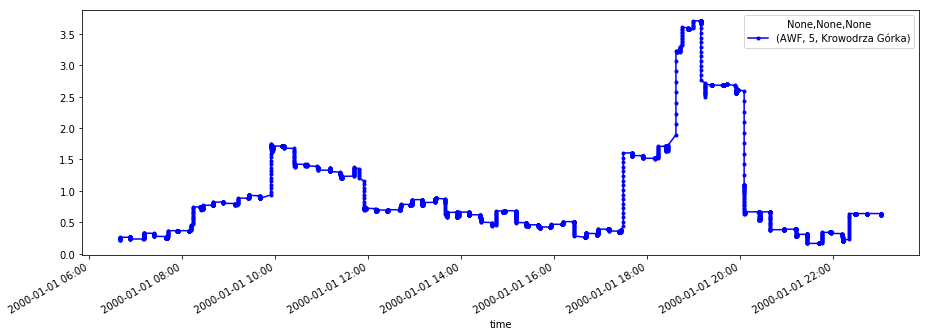

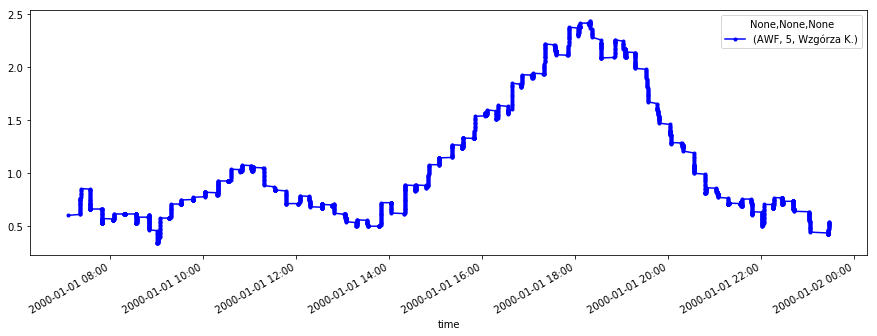

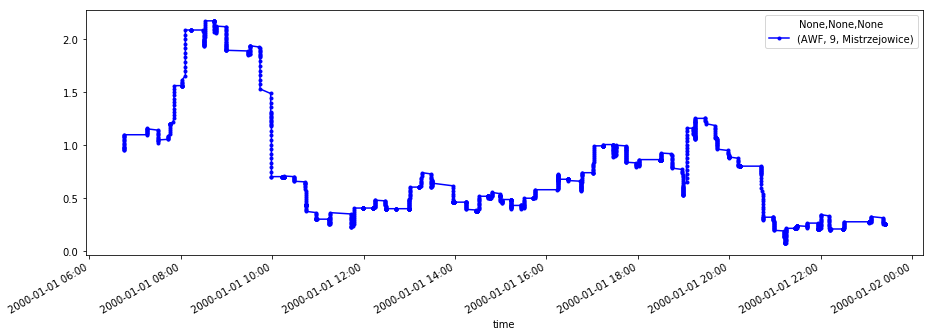

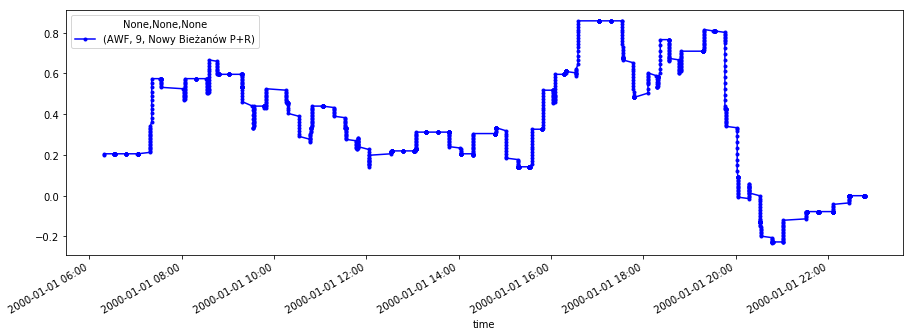

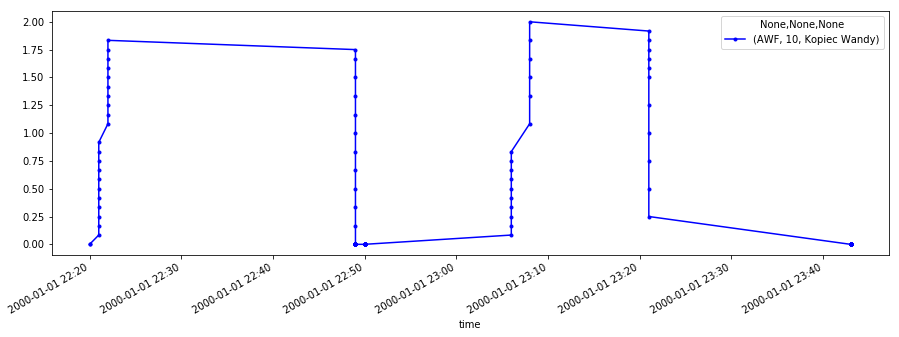

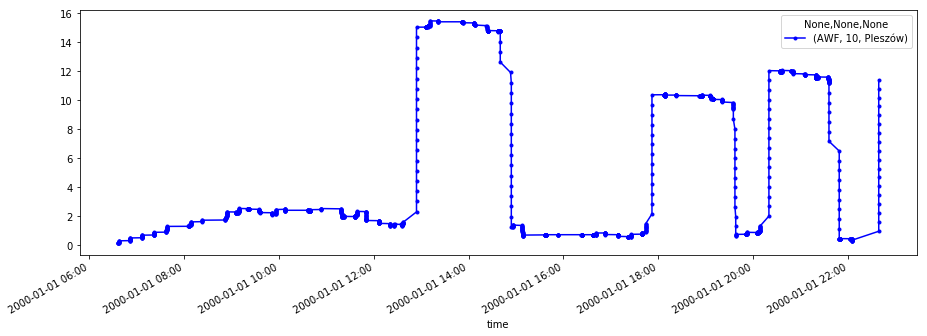

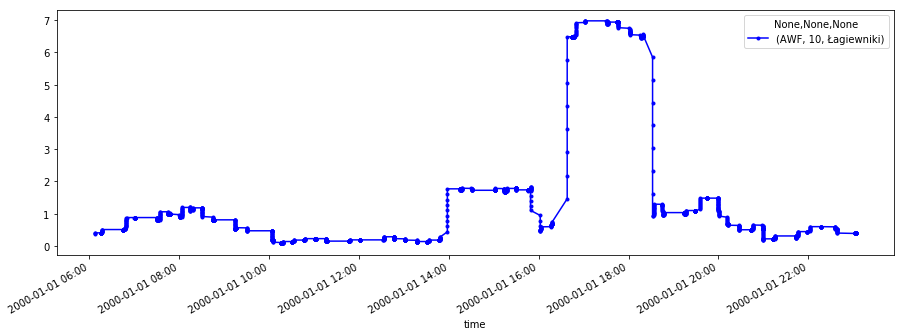

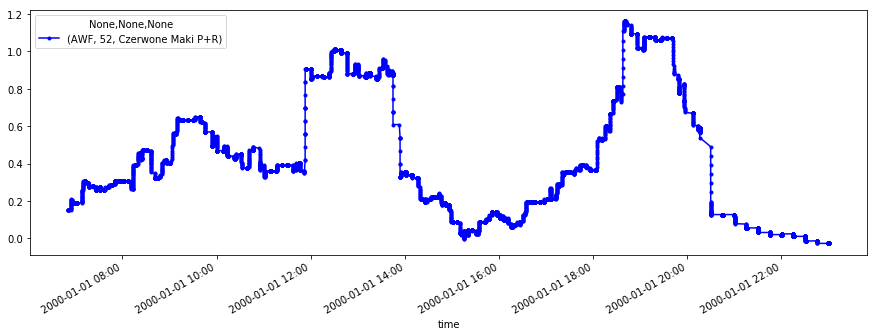

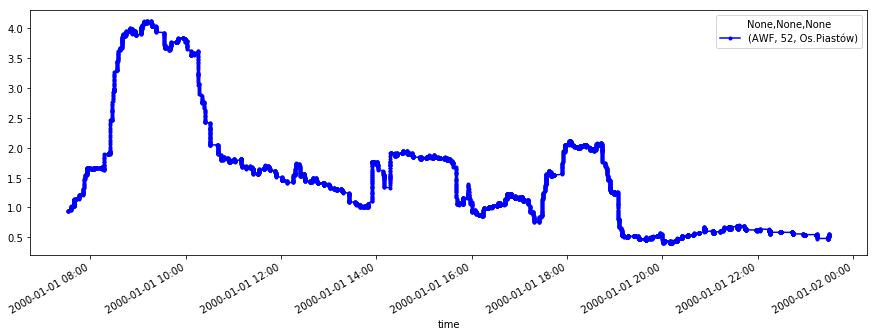

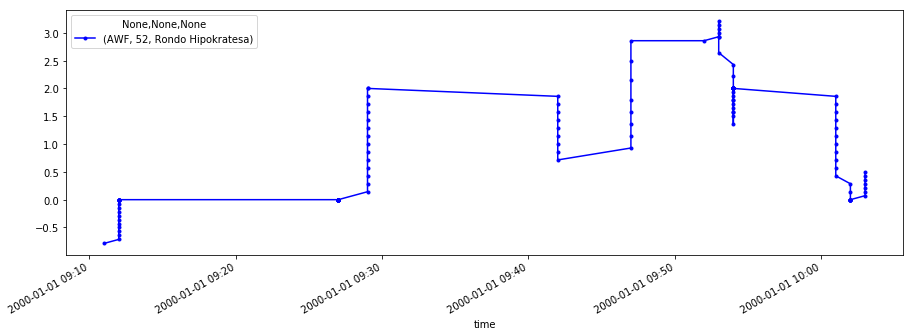

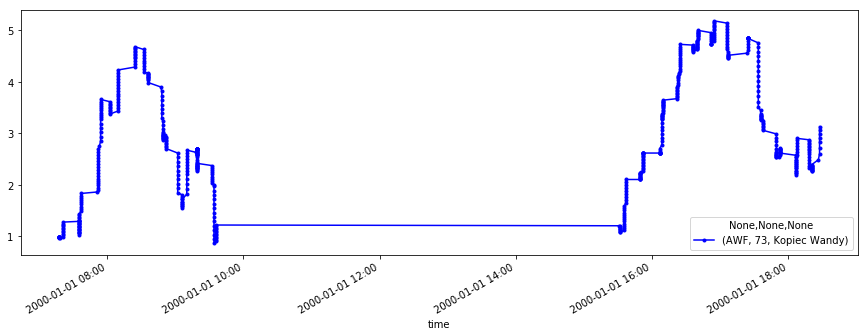

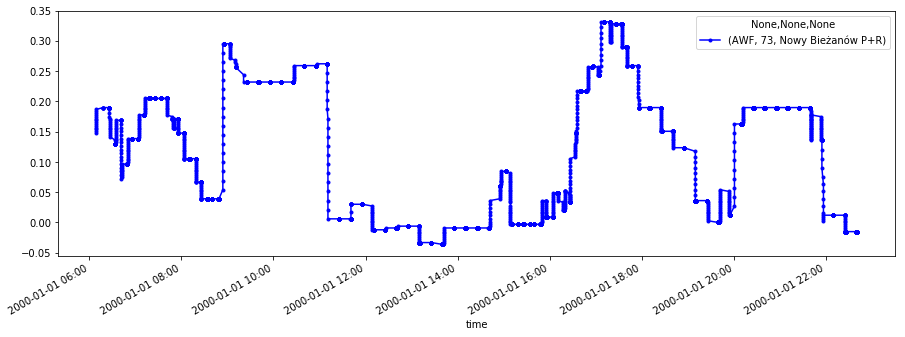

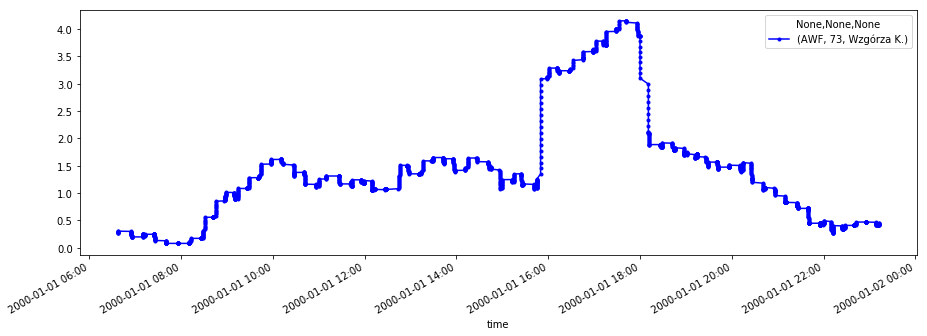

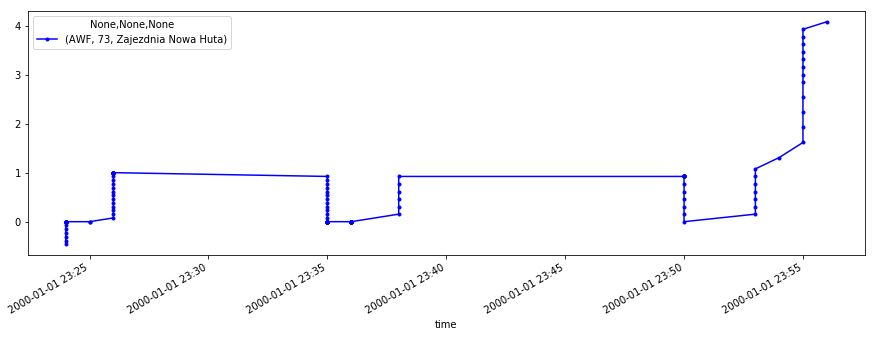

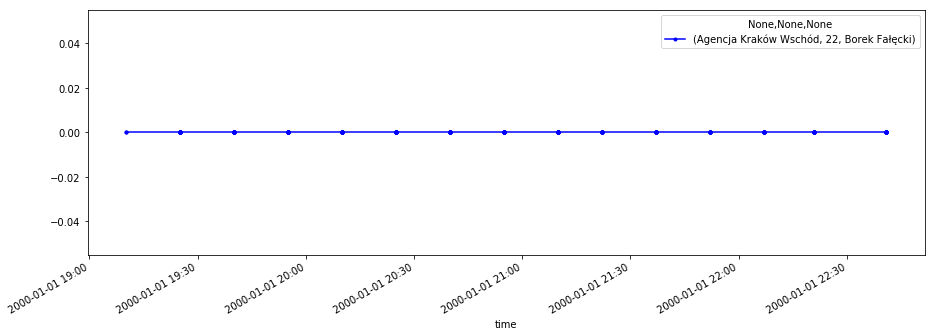

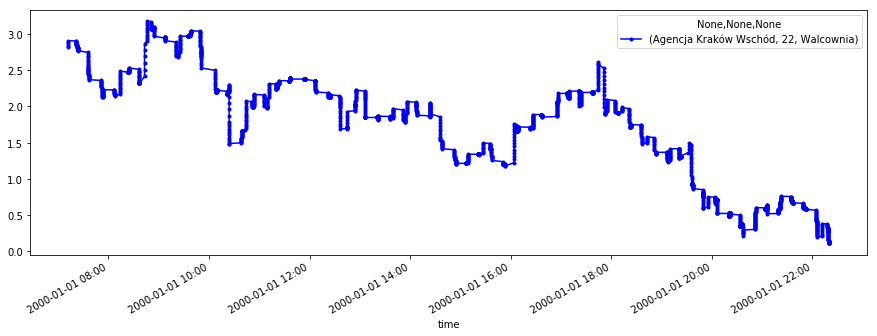

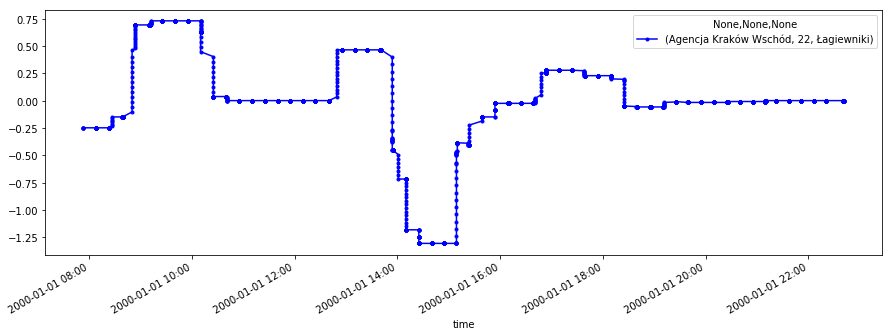

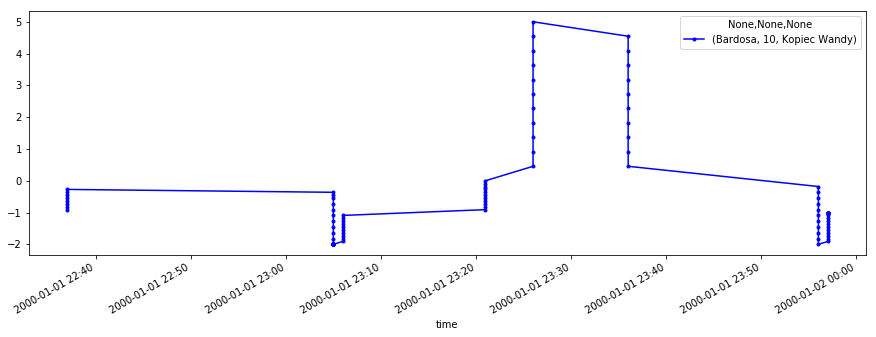

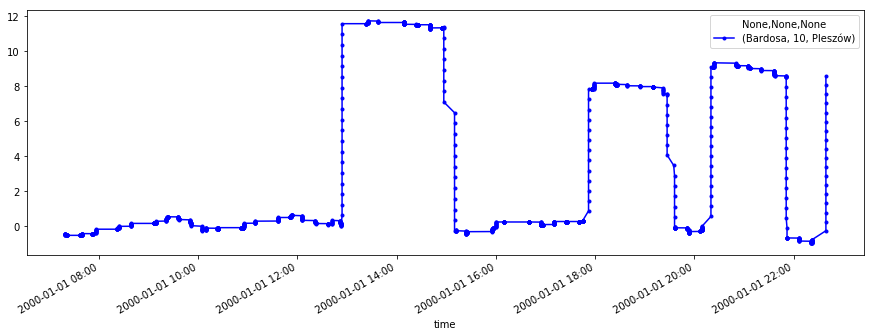

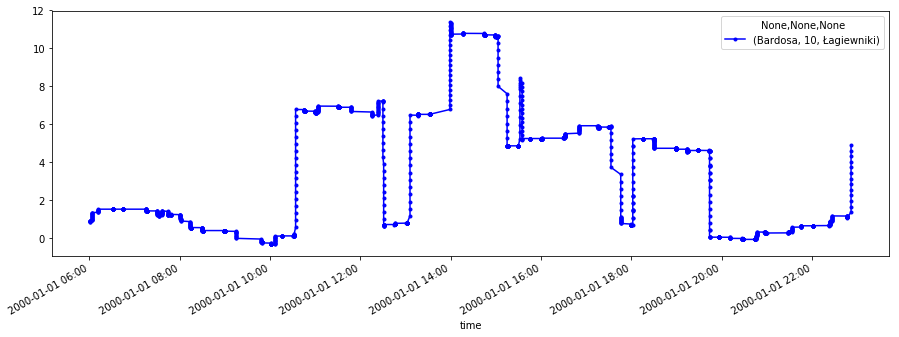

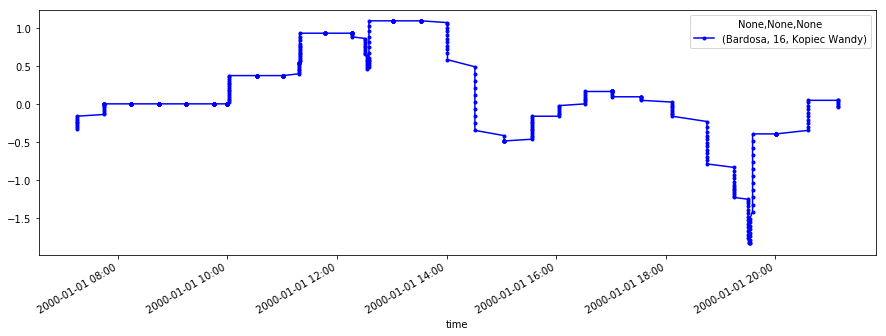

In [68]:
counter = 0
for key, grp in grouped_tram_delays:
    if len(grp['time'].values) > 100:
        grp['rolling_mean_delay'] = grp['delay'].rolling(int(len(grp['time'].values)/10)).mean()
        fig, ax = plt.subplots(1)
        grp.plot(ax=ax, style='.-', x='time', y='rolling_mean_delay', color='b', label=key)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.show()
        counter = counter + 1;
        if(counter > 20):
            break

In [102]:
def str_to_int_token(input_list):
    unique_list = list(set(input_list))
    out_list = [unique_list.index(x) for x in input_list]
    return out_list

In [103]:
tram_delays_df['direction'] = str_to_int_token(list(tram_delays_df['direction']))
tram_delays_df['stopName'] = str_to_int_token(list(tram_delays_df['stopName']))
tram_delays_df['time'] = str_to_int_token(list(tram_delays_df['time']))
feature_names = ['vehicleId', 'direction', 'patternText', 'tripId', 'stopName', 'time', 'day_of_week']

tram_delays_df.head(10)

,Unnamed: 0,vehicleId,direction,patternText,tripId,stopName,time,day_of_week,delay
1113642,1113642,6352185295672180860,19,22,6351558574044832787,16,775,2,-1
2027514,2027514,6352185295672181550,9,18,6351558574047683861,129,775,3,2
2027519,2027519,6352185295672180871,19,22,6351558574047761683,77,775,3,-1
2027522,2027522,6352185295672181339,12,62,6351558574048019716,5,775,3,1
2027526,2027526,6352185295672181384,11,3,6351558574048036099,13,775,3,0
2027549,2027549,6352185295672181347,8,69,6351558574048032004,90,775,3,0
2945563,2945563,6352185295672181367,12,62,6351558574047065604,5,775,4,1
2027559,2027559,6352185295672181550,9,18,6351558574047683861,129,775,3,2
2027565,2027565,6352185295672180871,19,22,6351558574047761683,77,775,3,-1
182632,182632,6352185295672180842,19,22,6351558574044848913,81,775,1,0


In [104]:
Xtr, Xv, ytr, yv = train_test_split(tram_delays_df[feature_names].values, tram_delays_df['delay'].values, test_size=0.2, random_state=1987)

In [108]:
start = time()
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
#dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 50,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=5,
                  maximize=False, verbose_eval=1)
end = time()
print("Time taken by above cell is {}.".format(end - start))
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.09076	valid-rmse:4.04778
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:4.08238	valid-rmse:4.03967
[2]	train-rmse:4.04486	valid-rmse:4.00244
[3]	train-rmse:4.01665	valid-rmse:3.97442
[4]	train-rmse:3.63022	valid-rmse:3.6144
[5]	train-rmse:3.4214	valid-rmse:3.42794
[6]	train-rmse:3.40775	valid-rmse:3.41548
[7]	train-rmse:3.37947	valid-rmse:3.38751
[8]	train-rmse:3.35267	valid-rmse:3.36407
[9]	train-rmse:3.34982	valid-rmse:3.36111
[10]	train-rmse:3.15483	valid-rmse:3.18296
[11]	train-rmse:3.1542	valid-rmse:3.18248
[12]	train-rmse:3.1528	valid-rmse:3.18102
[13]	train-rmse:3.15208	valid-rmse:3.18023
[14]	train-rmse:3.14396	valid-rmse:3.17319
Time taken by above cell is 137.82602214813232.
Modeling RMSLE 3.17319
